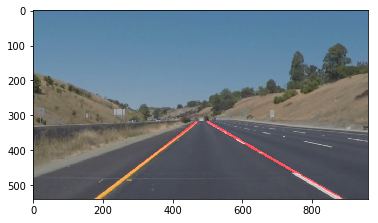

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import math
import os

%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)   

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    
    i=0
    l =0
    r=0
    rIntercept = 0
    lIntercept=0
    lSlope = 1
    rSlope =1
    lSlopeSum = 0
    rSlopeSum =0
    yRFinal =1000
    xRFinal = 0
    yRStart=0
    xRStart=0
    yLFinal =1000
    xLFinal = 0
    yLStart=0
    xLStart=0
    
    #looping through line coordinates. Taking slope for each line coordinates to average 
    #and also dividing image vertically for reducing noise. 
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if i<3:
                slope = ((y2-y1)/(x2-x1))
                #print (slope)
                if slope > 0 and x2>480 and x1>480: 
                    r = r+1
                    rSlopeSum=rSlopeSum+slope
                    if y2<yRFinal :
                        yRFinal= y2
                        xRFinal=x2
                    if y1>yRStart:
                        yRStart=y1
                        xRStart=x1
                if slope < 0 and x2<480 and x1<480:
                    l = l+1
                    lSlopeSum=lSlopeSum+slope
                    if y2<yLFinal  :
                        yLFinal= y2
                        xLFinal=x2
                    if y1>yLStart:                        
                        yLStart=y1
                        xLStart=x1
                    
    #Getting avg slope of right and left lane
    rSlope = rSlopeSum/r
    lSlope = lSlopeSum/l
    
    #Getting intercept for right and left lane
    #y = ax+b    
    lIntercept = yLFinal - (lSlope*xLFinal)
    rIntercept = yRFinal - (rSlope*xRFinal)
    
    #Getting x coordinates based on slope, intercept and y cordinates.
    #y=ax+b y-b=ax x= y-b/a
    xRStartDraw = int((540 - rIntercept)/rSlope)
    xREndDraw = int((320 - rIntercept)/rSlope)
    xLStartDraw = int((540 - lIntercept)/lSlope)
    xLEndDraw = int((320 - lIntercept)/lSlope)
    
    #drawing the line for right and left lane
    cv2.line(img, (xRStartDraw, 540), (xREndDraw, 320), color, thickness)
    cv2.line(img, (xLStartDraw, 540), (xLEndDraw, 320), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(img):
    
    # Making copy of oringal image.
    color_select = np.copy(img)
    
    grayimage = grayscale(color_select)
    
    #Blur the image
    guassianBlurImg = gaussian_blur(grayimage,7)
    #plt.imshow(guassianBlurImg, cmap='gray')
    #plt.show()
    
    #Canny Edge dection.
    cannyImg = cv2.Canny(guassianBlurImg,150,170)
    #plt.imshow(cannyImg, cmap='Greys_r')
    #plt.show()
    
    #limiting to region of interest
    imshape = img.shape
    vertices = np.array([[(70,imshape[0]),(430, 330), (550, 320), (860,540)]], dtype=np.int32)
    maskedImg = region_of_interest(cannyImg,vertices)
    #plt.imshow(maskedImg)
    #plt.show()

    # Hough transform 
    rho = 15 # distance resolution in pixels of the Hough grid
    theta= np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 125     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on

    lined_img = hough_lines(maskedImg, rho, theta, threshold,min_line_length, max_line_gap)
    
    # Drawing lines on image
    result = weighted_img(lined_img,img)
    plt.imshow(result)
    plt.show()
    
    #cv2.imwrite(img_name, weightedImg)
    return result

list = os.listdir("test_images/")

file_path = "./test_images/" + list[5]
processedImg = process_image(mpimg.imread(file_path))

#white_output = 'White.mp4'
#clip1 = VideoFileClip("solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process_image) 
#white_clip.preview()
#%time white_clip.write_videofile(white_output, audio=False)

#yellow_output = 'Yellow.mp4'
#clip2 = VideoFileClip("solidYellowLeft.mp4")
#yellow_clip = clip2.fl_image(process_image) 
#white_clip.preview()
#%time yellow_clip.write_videofile(yellow_output, audio=False)


